In [1]:
"""Sandbox module."""
from functools import partial

import matplotlib.pyplot as plt
import math
import numpy as np
import skfda
from scipy.stats import norm
from skfda.preprocessing.dim_reduction import FPCA

%matplotlib inline

# Nonparametric Statistics

## Kernel density estimation

In [2]:
kernels = {
    "Epanechnikov": lambda u: 3
    / (4 * np.sqrt(5))
    * (1 - (u**2) / 5)
    * int(abs(u) <= np.sqrt(5)),
    "Uniform": lambda u: 0.5 * int(abs(u) <= 1),
    "Triangular": lambda u: (1 - abs(u)) * int(abs(u) <= 1),
}

In [3]:
def kernel_estimator(x, h, sample, kernel_type):
    """Kernel density estimator function."""
    k = np.vectorize(kernels[kernel_type])
    return 1 / (len(sample) * h) * np.sum(k((x - sample) / h))

### Fix parameters and generate sample

In [4]:
n = 200
n_grid = 100
grid_ending = 10
mu = 0
sigma = 10

sample = np.random.default_rng(seed=28071995).normal(loc=mu, scale=sigma, size=n)
grid = np.linspace(start=-grid_ending, stop=grid_ending, num=n_grid)
# Rule-of-Thumb bandwidth (Li and Racine 2007, p. 66)
bandwidth = np.std(sample) * (n ** (-0.2))  # should implement optimal bandwidth

In [5]:
kernel_estimator_given_sample = partial(kernel_estimator, sample=sample)

### Generate fitted values

In [6]:
values_epa = [
    kernel_estimator_given_sample(x=i, h=bandwidth, kernel_type="Epanechnikov")
    for i in grid
]
values_uni = [
    kernel_estimator_given_sample(x=i, h=bandwidth, kernel_type="Uniform") for i in grid
]
values_tri = [
    kernel_estimator_given_sample(x=i, h=bandwidth, kernel_type="Triangular")
    for i in grid
]

### Plots

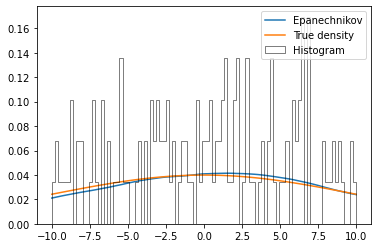

In [7]:
fig, ax = plt.subplots()
ax.plot(grid, values_epa, label="Epanechnikov")
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), label="True density")
# plot histogram for comparison
ax.hist(
    sample,
    bins=grid,
    density=True,
    histtype="step",
    edgecolor="black",
    linewidth=0.5,
    label="Histogram",
)
plt.legend()
plt.show()

## Kernel Regression

Context: we want to investigate the nonparametric regression relation $y_i = m(x_i) +
\epsilon_i$, where $y_i$ is a dependent variable, $x_i$ an explanatory variable, and
$\epsilon_i$ an iid error term, for observations $i = 1, ..., n$.

### Sample generation

In [8]:
def m(x):
    """True function."""
    return 3 * np.sin(x) + 2 * x

In [9]:
epsilon = np.random.default_rng(seed=28071995).normal(0, sigma / 2, size=n)
y = m(sample) + epsilon

In [10]:
def nw_estimator(x, y, h, sample, kernel_type):
    """Nadaraya - Watson / Local constant estimator."""
    k = np.vectorize(kernels[kernel_type])
    k0 = k((x - sample) / h)
    numerator = np.sum(k0 * y)
    denominator = np.sum(k0)
    return numerator / denominator

In [11]:
def ll_estimator(x, y, h, sample, kernel_type):
    """Local linear estimator. See Li & Racine, p. 81."""
    k = np.vectorize(kernels[kernel_type])
    k_0 = k((x - sample) / h)
    s_2 = np.sum(k_0 * (sample - x) ** 2)
    s_1 = np.sum(k_0 * (sample - x))
    w = k_0 * (s_2 - s_1 * (sample - x))
    numerator = np.sum(w * y)
    denominator = np.sum(w)
    return numerator / denominator

In [12]:
def ll_estimator2(x, y, h, sample, kernel_type):
    """Local linear estimator. See Li & Racine, p. 81."""
    k = np.vectorize(kernels[kernel_type])
    w = np.diag(k((sample - x) / h))
    z = np.array((np.ones(len(sample)), sample - x))
    return np.linalg.inv(z.dot(w).dot(z.transpose())).dot(z).dot(w).dot(y)

In [13]:
def loocv_error(h, y, sample, kernel_type):
    """Compute the LOOCV error for a given bandwidth."""
    error_nw = 0
    error_ll = 0
    estimator_nw = partial(nw_estimator, h=h, sample=sample, kernel_type=kernel_type)
    estimator_ll = partial(ll_estimator, h=h, sample=sample, kernel_type=kernel_type)

    # For each observation
    for i in range(len(sample)):
        # Create a new sample excluding the current observation
        sample_loo = np.delete(sample, i)
        y_loo = np.delete(y, i)

        # Update the sample and y in the estimator
        estimator_nw.keywords["sample"] = sample_loo
        estimator_nw.keywords["y"] = y_loo
        estimator_ll.keywords["sample"] = sample_loo
        estimator_ll.keywords["y"] = y_loo

        # Compute the prediction for the left-out observation
        prediction_nw = estimator_nw(x=sample[i])
        prediction_ll = estimator_ll(x=sample[i])

        # Add the squared error to the total error
        if not np.isnan(prediction_nw):
            error_nw += (y[i] - prediction_nw) ** 2
        if not np.isnan(prediction_ll):
            error_ll += (y[i] - prediction_ll) ** 2

    # Return the average error
    return error_nw / len(sample), error_ll / len(sample)


# List of bandwidths to consider
h_values = np.linspace(0.2, 2, 100)

# Compute the LOOCV error for each bandwidth
loocv_part = partial(loocv_error, sample=sample, y=y, kernel_type="Epanechnikov")
loocv_vec = np.vectorize(loocv_part)
errors = loocv_vec(h_values)

# Choose the bandwidth with the smallest error
loocv_h_nw, loocv_h_ll = h_values[np.argmin(errors, axis=1)]
f"Optimal bandwidth: {loocv_h_nw, loocv_h_ll}"

C:\Users\oecal\AppData\Local\Temp\ipykernel_20224\2469203197.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator
C:\Users\oecal\AppData\Local\Temp\ipykernel_20224\2160125314.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


'Optimal bandwidth: (0.2363636363636364, 0.2)'

In [14]:
temp1 = partial(
    nw_estimator,
    y=y,
    h=loocv_h_nw,
    sample=sample,
    kernel_type="Epanechnikov",
)
temp2 = np.vectorize(temp1)
temp3 = partial(
    ll_estimator,
    y=y,
    h=loocv_h_ll,
    sample=sample,
    kernel_type="Epanechnikov",
)
temp4 = np.vectorize(temp3)

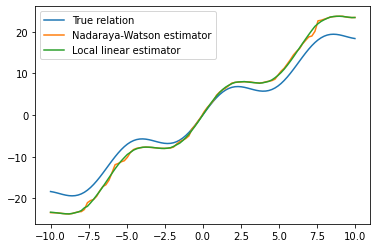

In [15]:
fig, ax = plt.subplots()
ax.plot(grid, m(grid), label="True relation")
ax.plot(grid, temp2(x=grid), label="Nadaraya-Watson estimator")
ax.plot(grid, temp4(x=grid), label="Local linear estimator")
plt.legend()
plt.show()

Apparently the Leave-One-Out Cross Validation algorithm gets stuck in a local optimum with very small bandwidths, at least for the Nadaraya-Watson estimator. I don't understand why, maybe because it can get perfect in sample fit if the observations are not so dense?

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [16]:
# Equispaced grid on [0, 1]
n = 200
gridnum = 100
grid_densities_univ = np.linspace(start=-5, stop=5, num=gridnum)
grid_quantiles_univ = np.linspace(start=0, stop=1, num=gridnum)


# Define normal density
def norm_density(x, mu, sigma):
    """Define normal density function.

    To test: columns of x must align with mu and sigma.
    """
    x = np.array(x)  # to vectorize the input
    mu = np.array(mu)
    sigma = np.array(sigma)
    return np.reciprocal(np.sqrt(2 * np.pi) * sigma) * np.exp(
        (-0.5) * ((x - mu) / sigma) ** 2,
    )

In [17]:
# Draw different sigmas
grid_densities = np.linspace(start=-np.ones(n), stop=np.ones(n), num=gridnum)
grid_quantiles = np.linspace(start=np.ones(n) * 0.01, stop=np.ones(n) * 0.99, num=gridnum)
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)
densities_discretized = norm_density(grid_densities, mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas)).transpose()

In [18]:
quantiles_discretized[0]

array([-1.06805943, -0.94386523, -0.86486608, -0.80538437, -0.75698015,
       -0.71577167, -0.67963597, -0.64727929, -0.61785201, -0.59076475,
       -0.56559099, -0.54201165, -0.5197814 , -0.4987073 , -0.47863473,
       -0.45943768, -0.44101204, -0.42327069, -0.40613992, -0.38955674,
       -0.37346688, -0.35782315, -0.34258424, -0.32771376, -0.3131794 ,
       -0.29895236, -0.28500678, -0.27131936, -0.25786897, -0.24463637,
       -0.23160396, -0.21875558, -0.2060763 , -0.19355229, -0.18117071,
       -0.16891952, -0.15678747, -0.14476394, -0.1328389 , -0.12100282,
       -0.10924664, -0.09756166, -0.08593955, -0.07437226, -0.062852  ,
       -0.05137118, -0.0399224 , -0.0284984 , -0.01709201, -0.00569617,
        0.00569617,  0.01709201,  0.0284984 ,  0.0399224 ,  0.05137118,
        0.062852  ,  0.07437226,  0.08593955,  0.09756166,  0.10924664,
        0.12100282,  0.1328389 ,  0.14476394,  0.15678747,  0.16891952,
        0.18117071,  0.19355229,  0.2060763 ,  0.21875558,  0.23

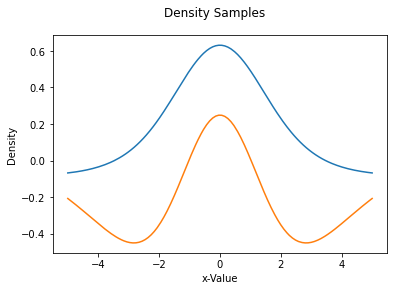

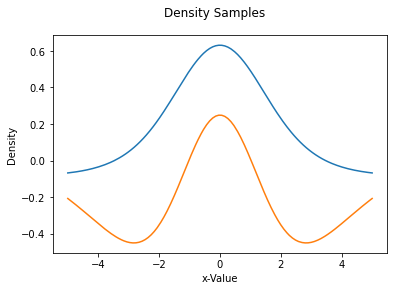

In [21]:
# Do FPCA via package
fpca_discretized = FPCA(n_components=2)
fd = skfda.FDataGrid(
    data_matrix=densities_discretized,
    grid_points=grid_densities_univ,
    dataset_name="Density Samples",
    argument_names=("x-Value",),
    coordinate_names=("Density",),
)
fpca_discretized.fit(fd)
fpca_discretized.components_.plot()

In [22]:
# Sample densities
partial_vectorized = np.vectorize(partial)
densities = partial_vectorized(norm_density, mu=mus, sigma=sigmas)

In [23]:
# Manual computation of FPCs, but bad! Better: replace it with np.mean of
# densities_discretized
# Sample Mean:
def sample_mean(x: float, sample_funcs: np.ndarray) -> float:
    """Compute mean function."""
    sum_of_funcs = 0
    for f in sample_funcs:
        sum_of_funcs += f(x)
    return 1 / len(sample_funcs) * sum_of_funcs

In [24]:
def sample_cov_func(x: float, y: float, mean_func: callable, sample_funcs: np.ndarray):
    """Compute covariance function."""
    x = np.array(x)
    y = np.array(y)
    mean_x = mean_func(x, sample_funcs)
    mean_y = mean_func(y, sample_funcs)
    sum_cross_products = 0
    sum_x_evals = 0
    sum_y_evals = 0
    for f in sample_funcs:
        sum_cross_products += f(x) * f(y)
        sum_x_evals += f(x)
        sum_y_evals += f(y)
    return mean_x * mean_y + 1 / len(sample_funcs) * (
        sum_cross_products - mean_x * sum_y_evals - mean_y * sum_x_evals
    )

In [25]:
def sample_cov_func2(x: float, y: float, mean_func: callable, sample_funcs: np.ndarray):
    """Compute covariance function."""
    x = np.array(x)
    y = np.array(y)
    mean_x = mean_func(x, sample_funcs)
    mean_y = mean_func(y, sample_funcs)
    sum_products = 0
    for f in sample_funcs:
        sum_products += (f(x) - mean_x) * (f(y) - mean_y)
    return 1 / len(sample_funcs) * sum_products

In [26]:
# See whether they agree on the the result, they should
sample_cov_func(0, 0.5, sample_mean, densities), sample_cov_func2(
    0,
    0.5,
    sample_mean,
    densities,
)

(0.028527227812849137, 0.02852722781284923)

In [27]:
%%timeit
approx_cov_func = np.zeros((gridnum, gridnum))
for i in range(gridnum):
    approx_cov_func[i] = sample_cov_func(
        grid_densities_univ,
        grid_densities_univ[i],
        sample_mean,
        densities,
    )

1.73 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
approx_cov_func2 = np.zeros((gridnum, gridnum))
for i in range(gridnum):
    approx_cov_func2[i] = sample_cov_func2(
        grid_densities_univ,
        grid_densities_univ[i],
        sample_mean,
        densities,
    )

1.4 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
approx_cov_np = np.cov(densities_discretized.transpose())

258 µs ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Numpy command obviously much faster, so won't use my own functions.

Now,

## Estimation of Eigenvectors

In [31]:
# Compute covariance matrix
approx_cov_np = np.cov(densities_discretized.transpose())

In [32]:
eig_vals, eig_vecs = np.linalg.eigh(approx_cov_np)
eig_vals2, eig_vecs2 = np.linalg.eigh(approx_cov_np)
eig_vals_sorted = eig_vals[np.argsort(-eig_vals)]
eig_vecs_sorted = eig_vecs[:, np.argsort(-eig_vals)]

In [33]:
diff = eig_vecs_sorted[:, 0] - eig_vecs[:, np.argmax(-eig_vals)]

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

In [34]:
def riemann_sum(a, b, m, f, method="left"):
    """Compute integral."""
    stepsize = (b - a) / m
    if method == "left":
        grid = np.linspace(a, b - stepsize, m)
    elif method == "right":
        grid = np.linspace(a + stepsize, b, m)
    else:
        msg = "Must specify either left or right Riemann sum!"
        raise ValueError(msg)
    return np.sum(f(grid) * stepsize)

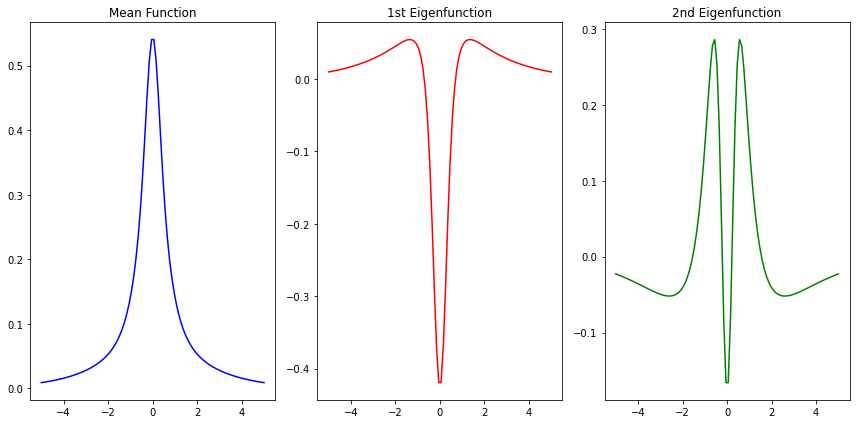

In [42]:
# 1. Generate synthetic functional data
n = 200
gridnum = 100
endpoint = 5
grid_densities = np.linspace(
    start=-np.ones(n) * endpoint,
    stop=np.ones(n) * endpoint,
    num=gridnum,
)
grid_densities_univ = np.linspace(start=-endpoint, stop=endpoint, num=gridnum)

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)
densities_discretized = norm_density(grid_densities, mus, sigmas).transpose()

# Generate curves with some random variation around a sine curve
data2 = np.array(
    [
        np.sin(4 * np.pi * grid_densities_univ)
        + 0.5 * np.random.default_rng(_).normal(0, 0.5, len(grid_densities_univ))
        for _ in range(n)
    ],
)

data = densities_discretized

# 2. Compute the mean function
mean_function = np.mean(data, axis=0)

# 3. Center the data
centered_data = data - mean_function

# 4. Estimate the covariance function using a discrete approximation
cov_matrix = np.cov(centered_data, rowvar=False)

# 5. Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenfunctions in decreasing order
eigenvalues_sorted = eigenvalues[np.argsort(-eigenvalues)]
eigenfunctions_sorted = eigenfunctions[:, np.argsort(-eigenvalues)]

# Adjust the lambda function to handle array input and interpolate values from the
# eigenvector

# Compute the L^2 norm for each column (eigenvector) over the domain using riemann_sum
l2_norms_riemann = np.array(
    np.sqrt(
        [
            riemann_sum(
                -1,
                1,
                gridnum,
                lambda x, i=i: np.interp(
                    x,
                    grid_densities_univ,
                    eigenfunctions_sorted[:, i] ** 2,
                ),
            )
            for i in range(gridnum)
        ],
    ),
)

# Scale each column of the eigenfunctions matrix by its respective L^2 norm using
# broadcasting
eigenfunctions_scaled_riemann = eigenfunctions_sorted / l2_norms_riemann

# Check the first few L^2 norms to verify
first_few_norms_riemann = np.array(
    [
        riemann_sum(
            -1,
            1,
            gridnum,
            lambda x, i=i: np.interp(
                x,
                grid_densities_univ,
                eigenfunctions_scaled_riemann[:, i] ** 2,
            ),
        )
        for i in range(5)
    ],
)

# 6. Project the centered data onto the eigenfunctions
fpc_scores_riemann_integral = np.array(
    [
        riemann_sum(
            0,
            1,
            len(grid_densities_univ),
            lambda x, centered_curve=centered_curve, eigenfunction=eigenfunction: np.interp(
                x,
                grid_densities_univ,
                centered_curve,
            )
            * np.interp(x, grid_densities_univ, eigenfunction),
        )
        for centered_curve in centered_data
        for eigenfunction in eigenfunctions_scaled_riemann.T
    ],
).reshape(n, -1)
fpc_scores = np.dot(centered_data, eigenfunctions_scaled_riemann)

# Plot the mean function and the first two eigenfunctions
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(grid_densities_univ, mean_function, "b-")
plt.title("Mean Function")

plt.subplot(1, 3, 2)
plt.plot(grid_densities_univ, eigenfunctions_sorted[:, 0], "r-")
plt.title("1st Eigenfunction")

plt.subplot(1, 3, 3)
plt.plot(grid_densities_univ, eigenfunctions_sorted[:, 1], "g-")
plt.title("2nd Eigenfunction")

plt.tight_layout()
plt.show()

In [43]:
fpc_scores[1][0], fpc_scores[1][1], fpc_scores_riemann_integral[1][0], fpc_scores_riemann_integral[1][1]

(-3.1680950938011323,
 0.6816995595744392,
 -0.14211629086579217,
 0.029465120944123645)

In [44]:
eigenfunctions.shape
centered_data.shape
data.shape
cov_matrix.shape

(100, 100)

In [45]:
fpc_scores_riemann_integral[0][0], fpc_scores_riemann_integral[0][1], fpc_scores[0][
    0
], fpc_scores[0][1]

(-0.14182956744724914,
 0.02963610220229506,
 -3.162160746151825,
 0.685622182956291)

In [46]:
l2_norms_riemann_scaled = np.array(
    [
        np.sqrt(
            riemann_sum(
                -1,
                1,
                gridnum,
                lambda grid, i=i: np.interp(
                    grid,
                    grid_densities_univ,
                    eigenfunctions_scaled_riemann[:, i] ** 2,
                ),
            ),
        )
        for i in range(gridnum)
    ],
)

In [47]:
l2_norms_riemann[0], l2_norms_riemann_scaled[0]

(0.30282839537820533, 1.0)

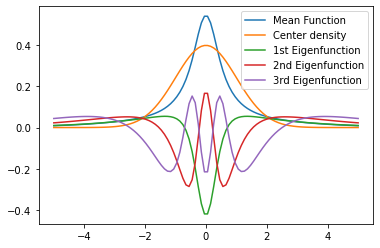

(<matplotlib.legend.Legend at 0x20c7a59d670>, None)

In [49]:
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, mean_function, label="Mean Function")
ax.plot(grid_densities_univ, norm.pdf(grid_densities_univ, loc=0, scale=1), label="Center density")
ax.plot(grid_densities_univ, eigenfunctions_sorted[:, 0], label="1st Eigenfunction")
ax.plot(grid_densities_univ, -eigenfunctions_sorted[:, 1], label="2nd Eigenfunction")
ax.plot(grid_densities_univ, eigenfunctions_sorted[:, 2], label="3rd Eigenfunction")
plt.legend(), plt.show()

## More reproducing of Petersen & Müller (2016)

In [50]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues_sorted[0:k]) / np.sum(eigenvalues_sorted)


fve(2)

0.9761200610430837

In [51]:
def mode_of_variation(alpha, mean_func, eigval, eigfunc):
    """Compute kth mode of variation."""
    return mean_func + alpha * np.sqrt(eigval) * eigfunc

In [52]:
first_mode = mode_of_variation(
    1,
    mean_function,
    eigenvalues_sorted[0],
    eigenfunctions_sorted[:, 0],
)
second_mode = mode_of_variation(
    1,
    mean_function,
    eigenvalues_sorted[1],
    eigenfunctions_sorted[:, 1],
)

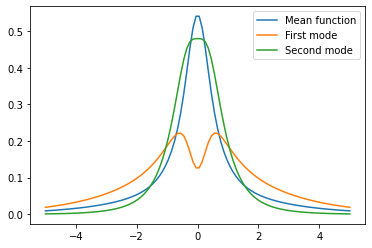

In [53]:
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, mean_function, label="Mean function")
ax.plot(grid_densities_univ, first_mode, label="First mode")
ax.plot(grid_densities_univ, second_mode, label="Second mode")
plt.legend()
plt.show()

In [73]:
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas)).transpose()

In [74]:
quantiles_discretized.shape, quantile_densities_discretized.shape

((200, 100), (200, 100))

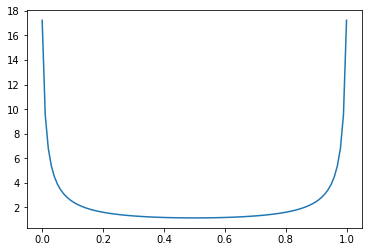

In [66]:
plt.plot(grid_quantiles_univ, quantile_densities_discretized[0])

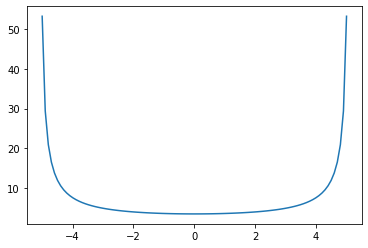

In [59]:
mean_qd_func = np.mean(quantile_densities_discretized, axis=0)
plt.plot(grid_densities_univ, mean_qd_func)

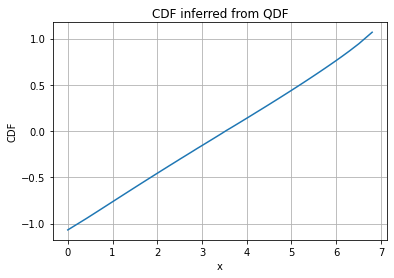

In [60]:
# Example QDF (replace with your own function)
qdf_values = mean_qd_func

# Generate probability values from 0 to 1
p_values = np.linspace(0, 1, 100)

# Integrate the QDF to get the quantile function using Riemann sums
quantile_function = [riemann_sum(0, p, 100, lambda x: np.interp(x, p_values, qdf_values), method="left") for p in p_values]

# Invert the quantile function to get the CDF
cdf_values = p_values
x_values = quantile_function

# Plot the CDF
plt.plot(x_values, quantiles_discretized[0])
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('CDF inferred from QDF')
plt.grid(True)
plt.show()

In [61]:
from scipy.integrate import cumtrapz

# Generate probability values from 0 to 1
p_values = np.linspace(0.01, 0.99, 100)

# Integrate the QDF to get the quantile function using Riemann sums
quantile_function = [riemann_sum(0, p, 100, lambda x: np.interp(x, p_values, qdf_values), method="left") for p in p_values]
# Assume qdf_values is your vector of QDF evaluations at 100 evenly spaced points in [0,1]
qdf_values = 1 / norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas)


# Integrate the QDF to get the quantile function
quantile_function = cumtrapz(qdf_values, p_values, initial=0)

# Invert the quantile function to get the CDF
cdf_values = p_values
x_values = quantile_function

# Plot the CDF
plt.plot(x_values, cdf_values)
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('CDF inferred from QDF')
plt.grid(True)
plt.show()

ValueError: If given, length of x along axis must be the same as y.

In [62]:
qdf_values = np.reciprocal(norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas))

In [63]:
quantile_densities_discretized

array([[ 17.22616643,   9.52310111,   6.78543825, ...,   6.78543825,
          9.52310111,  17.22616643],
       [ 17.20873771,   9.51346603,   6.77857302, ...,   6.77857302,
          9.51346603,  17.20873771],
       [ 34.14076698,  18.87395999,  13.44814977, ...,  13.44814977,
         18.87395999,  34.14076698],
       ...,
       [ 27.4804387 ,  15.19194636,  10.82462663, ...,  10.82462663,
         15.19194636,  27.4804387 ],
       [106.41620482,  58.82982047,  41.91765995, ...,  41.91765995,
         58.82982047, 106.41620482],
       [101.74236871,  56.24599463,  40.07662198, ...,  40.07662198,
         56.24599463, 101.74236871]])